# # Original Code (Unmodified)

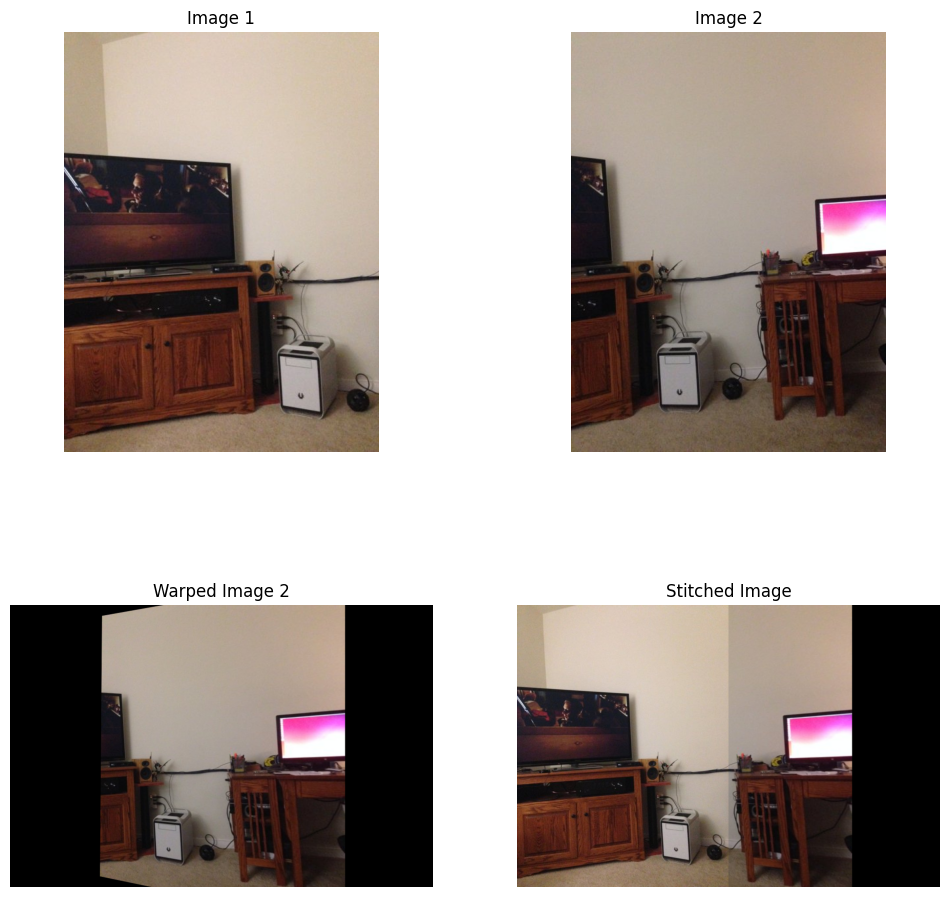

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read the images
image1 = cv2.imread('stitch1.jpg')
image2 = cv2.imread('stitch2.jpg')
# Convert images to grayscale
gray_image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
gray_image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
# Create SIFT object
sift = cv2.SIFT_create()
# Detect keypoints and compute descriptors for both images
keypoints1, descriptors1 = sift.detectAndCompute(gray_image1, None)
keypoints2, descriptors2 = sift.detectAndCompute(gray_image2, None)
# Match keypoints between the two images
bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptors1, descriptors2, k=2)
# Apply ratio test to select good matches
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

# Minimum number of matches required for homography
MIN_MATCH_COUNT = 10
if len(good_matches) >= MIN_MATCH_COUNT:
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    # Estimate homography matrix using RANSAC (Inverse Warping!)
    homography, _ = cv2.findHomography(dst_pts,src_pts, cv2.RANSAC, 5.0)
    # Warp the second image to align with the first image
    stitched_image = cv2.warpPerspective(image2, homography, (image1.shape[1] + image2.shape[1], image2.shape[0]))
    warpedImage2 =stitched_image.copy()
    stitched_image[:image1.shape[0], :image1.shape[1]] = image1

    # Display images in two rows
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))

    # Display image1 in the first row, first column
    axs[0, 0].imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
    axs[0, 0].set_title('Image 1')
    axs[0, 0].axis('off')

    # Display image2 in the first row, second column
    axs[0, 1].imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
    axs[0, 1].set_title('Image 2')
    axs[0, 1].axis('off')

    # Display stitched_image in the second row, spanning both columns
    axs[1, 0].imshow(cv2.cvtColor(warpedImage2, cv2.COLOR_BGR2RGB))
    axs[1, 0].set_title('Warped Image 2')
    axs[1, 0].axis('off')

    # Hide the second subplot in the second row
    axs[1, 1].imshow(cv2.cvtColor(stitched_image, cv2.COLOR_BGR2RGB))
    axs[1, 1].set_title('Stitched Image')
    axs[1, 1].axis('off')

    #plt.tight_layout()
    plt.show(block=True)
else:
    print("Not enough matches are found - %d/%d" % (len(good_matches), MIN_MATCH_COUNT))


## Home Task 4A Version 1(Modified)


1. **Initializing the Stitching Process with the First Image:** by setting the `stitched_image` variable to the first image in the provided list.

2. **Iterating Over Images to Perform Pairwise Stitching:** Beyond first, both the current stitched image and the next image in sequence to grayscale.

3. **Feature Detection and Description with SIFT Algo:** to detect keypoints and compute descriptors in both stitched / next image.

4. **Keypoint Matching Using Brute-Force Matcher:** Compares descriptors from the two images to find the best matches. KNN (k=2) for top two matches. matches.

5. **Filtering Matches with the Ratio Test:** Ratio test to retain only those that are significantly better than their second-best match. Matches with a high degree of confidence are used for computing the homography.

6. **Homography Estimation and Image Warping:** For each pair of images with a sufficient number of good matches, a homography matrix is estimated with RANSAC algo to define transformation needed to align next with the stitched image. The next image is then warped according to this homography. to expand panorama.

7. **Updating the Stitched Image:** Warped / current stitched image combined by updating the pixel values using overlapping areas. Non-black pixels from the stitched image replace corresponding pixels in the warped image, preserving the continuity and integrity of the stitched panorama.

8. Code systematically stitches multiple images that each new image is properly aligned and integrated into the growing panorama. Ierative process of homography estimation / image warping for each image pair, followed by the careful combination of images, fulfills the requirement of stitching all three images together into a single, cohesive panorama.


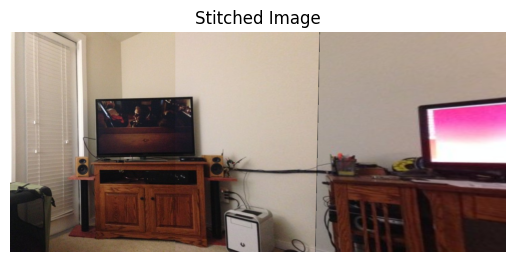

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def stitch_images(images):
    # Initialize the final stitched image as the first image
    stitched_image = images[0]
    for i in range(1, len(images)):
        # Convert images to grayscale
        gray_imageA = cv2.cvtColor(stitched_image, cv2.COLOR_BGR2GRAY)
        gray_imageB = cv2.cvtColor(images[i], cv2.COLOR_BGR2GRAY)
        # Create SIFT object
        sift = cv2.SIFT_create()
        # Detect keypoints and compute descriptors for both images
        keypointsA, descriptorsA = sift.detectAndCompute(gray_imageA, None)
        keypointsB, descriptorsB = sift.detectAndCompute(gray_imageB, None)
        # Match keypoints between the two images
        bf = cv2.BFMatcher()
        matches = bf.knnMatch(descriptorsA, descriptorsB, k=2)
        # Apply ratio test to select good matches
        good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]

        MIN_MATCH_COUNT = 10
        if len(good_matches) >= MIN_MATCH_COUNT:
            src_pts = np.float32([keypointsA[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
            dst_pts = np.float32([keypointsB[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
            # Estimate homography matrix using RANSAC
            homography, _ = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)
            # Warp the next image to align with the stitched image so far
            warped_image = cv2.warpPerspective(images[i], homography, (stitched_image.shape[1] + images[i].shape[1], stitched_image.shape[0]))
            # Update the stitched image by placing the current stitched image onto the warped image
            non_black_pixels = np.any(stitched_image != [0, 0, 0], axis=-1)
            warped_image[0:stitched_image.shape[0], 0:stitched_image.shape[1]][non_black_pixels] = stitched_image[non_black_pixels]
            stitched_image = warped_image
        else:
            print("Not enough matches are found - %d/%d" % (len(good_matches), MIN_MATCH_COUNT))
            return None
    return stitched_image

# Read the images
images = [cv2.imread(f'stitch{i}.jpg') for i in range(3)]

# Stitch the images together
final_result = stitch_images(images)

if final_result is not None:
    # Display the final stitched image
    plt.imshow(cv2.cvtColor(final_result, cv2.COLOR_BGR2RGB))
    plt.title('Stitched Image')
    plt.axis('off')
    plt.show()


## Home Task 4A Version 2

1. **Initialization with SIFT for Feature Detection:** 

2. **Accumulating Keypoints and Descriptors Across Images:** All keypoints and their corresponding descriptors are stored in two lists.

3. **Pairwise Matching with Brute-Force Matcher and Ratio Test:** For each possible pair of images, a Brute-Force Matcher is used for KNN(k=2). The ratio test is then applied to these matches, filtering out not meeting a specific distance criterion.

4. **Prioritizing Image Pairs Based on Match Quality:** The pairs of images, along with their good matches, are sorted in descending order.

5. **Sequential Stitching Based on Best Matches:** Starting with the image pair that has the highest number of good matches, the stitching process iterates through the images. For each iteration, the homography matrix is computed using the RANSAC algorithm to accommodate outliers and errors in match selection. This matrix is then used to warp the next image to align with current stitched composition.

6. **Blending Overlapping Regions for Seamless Transitions:** The `blend_images` function is designed to smoothly merge overlapping areas between stitched images. By calculating the overlap width and applying a blending function that adjusts pixel values based on their position within the overlap, the function ensures a gradual transition.

7. **Iterative Homography and Blending for Each Image Pair:** The process repeats for each subsequent pair of images, each time updating the stitched composition and ensuring that the new image is properly aligned and blended.



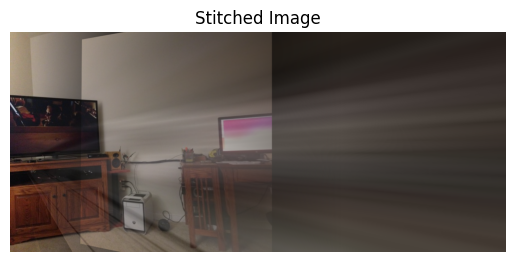

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def find_best_matches(images):
    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    # List to hold all keypoints and descriptors
    all_keypoints = []
    all_descriptors = []

    # Detect keypoints and descriptors for all images
    for image in images:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        keypoints, descriptors = sift.detectAndCompute(gray_image, None)
        all_keypoints.append(keypoints)
        all_descriptors.append(descriptors)

    # Find best pairwise matches
    bf = cv2.BFMatcher()
    best_matches = []
    for i in range(len(images)):
        for j in range(i + 1, len(images)):
            matches = bf.knnMatch(all_descriptors[i], all_descriptors[j], k=2)
            # Apply ratio test
            good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]
            if good_matches:
                best_matches.append((i, j, good_matches))

    # Sort pairs by number of good matches (descending)
    best_matches.sort(key=lambda x: len(x[2]), reverse=True)

    return best_matches, all_keypoints, all_descriptors

def blend_images(imageA, imageB):
    # Determine the overlap width based on the minimum width of the two images
    rowsA, colsA = imageA.shape[:2]
    rowsB, colsB = imageB.shape[:2]
    min_cols = min(colsA, colsB)

    # Initialize the overlap flag
    overlap_found = False

    # Find the start of the overlap in imageB from the left
    for col in range(min_cols):
        if np.sum(imageB[:, col]) > 0:
            start_overlap = col
            overlap_found = True
            break

    if overlap_found:
        # Calculate the blending width as the distance from the start of the overlap to the end of the shorter image
        blend_width = min_cols - start_overlap

        # Perform blending in the overlapping region
        for i in range(blend_width):
            alpha = i / blend_width
            imageA[:, start_overlap + i] = alpha * imageA[:, start_overlap + i] + (1 - alpha) * imageB[:, start_overlap + i]

        # Update non-overlapping regions
        imageA[:, :start_overlap] = imageB[:, :start_overlap]

    return imageA



def stitch_images(images):
    best_matches, all_keypoints, all_descriptors = find_best_matches(images)

    if not best_matches:
        print("No good matches found between any images.")
        return None

    # Start with the pair that has the highest number of good matches
    base_idx, next_idx, good_matches = best_matches[0]
    stitched_image = images[base_idx]
    for _ in range(len(images) - 1):
        # Find good matches for the current base_idx and next_idx
        if not best_matches:  # If there are no more matches to process
            break  # Exit the loop as we can't stitch further

        _, next_idx, current_good_matches = best_matches.pop(0)  # Get the next best match

        # Proceed only if there are enough good matches
        if len(current_good_matches) < MIN_MATCH_COUNT:
            continue  # Skip to the next iteration if not enough matches

        # Filter out matches with indices that are out of range
        valid_matches = [m for m in current_good_matches if m.queryIdx < len(all_keypoints[base_idx]) and m.trainIdx < len(all_keypoints[next_idx])]

        # Proceed only if there are enough valid matches
        if len(valid_matches) < MIN_MATCH_COUNT:
            print(f"Not enough valid matches between image {base_idx} and image {next_idx}.")
            continue  # Skip to the next iteration

        # Now, use valid_matches to find src_pts and dst_pts
        try:
            src_pts = np.float32([all_keypoints[base_idx][m.queryIdx].pt for m in valid_matches]).reshape(-1, 1, 2)
            dst_pts = np.float32([all_keypoints[next_idx][m.trainIdx].pt for m in valid_matches]).reshape(-1, 1, 2)
        except IndexError as e:
            print(f"Unexpected IndexError: {e}")
            continue  # Skip to the next iteration

        homography, _ = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)

        # Calculate size of the resulting stitched image
        stitched_height = max(stitched_image.shape[0], images[next_idx].shape[0])
        stitched_width = stitched_image.shape[1] + images[next_idx].shape[1]

        # Warp the next image
        warped_image = cv2.warpPerspective(images[next_idx], homography, (stitched_width, stitched_height))

        # Create a mask to identify where to blend images
        mask = np.zeros_like(warped_image, dtype=bool)
        mask[0:stitched_image.shape[0], 0:stitched_image.shape[1]] = True

        # Blend the stitched image onto the warped image using the mask
        stitched_image = blend_images(warped_image, stitched_image)


        # Update base_idx for the next iteration (if needed)
        base_idx = next_idx
        if len(best_matches) > 1:
            _, next_idx, good_matches = best_matches[1]
            best_matches.pop(0)

    return stitched_image

# Read the images
images = [cv2.imread(f'stitch{i}.jpg') for i in range(3)]

# Stitch the images together
final_result = stitch_images(images)

if final_result is not None:
    # Display the final stitched image
    plt.imshow(cv2.cvtColor(final_result, cv2.COLOR_BGR2RGB))
    plt.title('Stitched Image')
    plt.axis('off')
    plt.show()


## Home Task 4B 


1. **Initialization with the First Image:** by setting the first image in the sequence as the base (`stitched_image`) for subsequent stitching. It serves a starting point from which additional images can be added, expanding panorama.

2. **Grayscale Conversion for Feature Detection:** Each image, including the current `stitched_image` / next in the sequence, is converted to grayscale.

3. **Feature Detection Using SIFT:** The Scale-Invariant Feature Transform (SIFT) algo to detect and describe keypoints in both the grayscale versions of the stitched image / next image.

4. **Descriptor Matching with FLANN:** The Fast Library for Approximate Nearest Neighbors (FLANN) used for eff matching of SIFT descriptors b/w two images.

5. **Lowe's Ratio Test for Match Filtering:** Further filtered using Lowe's ratio test, retaining those closest neighbor to the distance of the second-closest neighbor is less than a threshold (typically 0.75). Th estep effectively removes less reliable matches, ensuring only best matches.

6. **Homography Computation and Image Warping:** Using the RANSAC algo, which robustly estimates the transformation needed to align the next image with the stitched / next image for blending into the stitched panorama.

7. **Seamless Blending with Seamless Clone:** `cv2.seamlessClone` is utilized. To minimizes visible seams, using a mask to define the blending region. The `MIXED_CLONE` flag ensures a smooth transition in the overlap area, removing any visible seams and achieving a natural-looking panoramic image.

8. Stitching done for all three specified images into a single panorama and applying a blending algorithm (`cv2.seamlessClone` with `MIXED_CLONE`) to remove seams, creating a cohesive and visually appealing panoramic image.

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def stitch_images(images):
    # Initialize with the first image
    stitched_image = images[0]
    for i in range(1, len(images)):
        # Convert images to grayscale for feature detection
        gray_image1 = cv2.cvtColor(stitched_image, cv2.COLOR_BGR2GRAY)
        gray_image2 = cv2.cvtColor(images[i], cv2.COLOR_BGR2GRAY)

        # Detect features and compute descriptors
        sift = cv2.SIFT_create()
        keypoints1, descriptors1 = sift.detectAndCompute(gray_image1, None)
        keypoints2, descriptors2 = sift.detectAndCompute(gray_image2, None)

        # Match descriptors using FLANN matcher
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)
        flann = cv2.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(descriptors1, descriptors2, k=2)

        # Filter matches using the Lowe's ratio test
        good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]

        if len(good_matches) > 10:
            src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
            dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

            # Compute Homography
            homography, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

            # Warp the next image towards the stitched image space
            warped_image = cv2.warpPerspective(images[i], homography, (stitched_image.shape[1] + images[i].shape[1], stitched_image.shape[0]))

            # Create a mask to identify the overlap area for blending
            mask = np.zeros((warped_image.shape[0], warped_image.shape[1]), dtype=np.uint8)
            mask[:stitched_image.shape[0], :stitched_image.shape[1]] = 255

            # Use seamlessClone for blending in the overlap area
            mixed_clone = cv2.seamlessClone(warped_image, stitched_image, mask, (int(stitched_image.shape[1]/2), int(stitched_image.shape[0]/2)), cv2.MIXED_CLONE)

            stitched_image = mixed_clone
        else:
            print(f"Not enough matches found - {len(good_matches)}/10. Skipping this image.")

    return stitched_image

# Load images
images = [cv2.imread(f'stitch{i}.jpg') for i in range(3)]

# Stitch images
final_result = stitch_images(images)

# Display the result
if final_result is not None:
    plt.imshow(cv2.cvtColor(final_result, cv2.COLOR_BGR2RGB))
    plt.title('Stitched Image')
    plt.axis('off')
    plt.show()


error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [1]:
import cv2 # OpenCV library for image processing
import numpy as np # NumPy library for numerical operations
import matplotlib.pyplot as plt
# Step 1: Load images
reference_img = cv2.imread('reference1Km.tif') # Load the reference image
if reference_img is None:
    print(f'Reference image not loaded, please check the path.')
else:
    print(f'Reference image loaded, shape: {reference_img.shape}')
# Load the aerial images
aerial_imgs = []
for i in range(1, 11):
    img = cv2.imread(f'aerial{i}.png')
    if img is None:
        print(f'Aerial image {i} not loaded, please check the path.')
    else:
        print(f'Aerial image {i} loaded, shape: {img.shape}')
        aerial_imgs.append(img)
# Step 2: User selects an aerial image and clicks a pixel
# This step requires a GUI for image display and pixel selection, which is not shown here
# For the purpose of this example, let's assume the user selected the first aerial image and clicked the 
selected_img = aerial_imgs[0]
x, y = selected_img.shape[1] // 2, selected_img.shape[0] // 2
# Step 3: Compute keypoints and descriptors
# You need to give option to try at least two different detectors/descriptor methods (e.g., SIFT, HOG, SU
# Here, we use ORB as an example
orb = cv2.ORB_create() # Initialize ORB detector
kp1, des1 = orb.detectAndCompute(reference_img, None) # Compute keypoints and descriptors for reference 
kp2, des2 = orb.detectAndCompute(selected_img, None) # Compute keypoints and descriptors for selected ae
# Step 4: Compute Homography matrix
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True) # Initialize BFMatcher with Hamming distance and c
matches = bf.match(des1, des2) # Match descriptors between the two images
matches = sorted(matches, key=lambda x: x.distance) # Sort matches based on distance (lower is better)
src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2) # Get source points from r
dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2) # Get destination points f
H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0) # Compute Homography matrix using RANSAC
# Step 5: Using the H matrix project the clicked pixel location to reference image pixel location

clicked_location = np.array([x, y, 1]) # x, y are the coordinates of the clicked pixel
projected_location = np.dot(H, clicked_location) # Project clicked location to reference image using Hom
projected_location = projected_location / projected_location[2] # Normalize the projected location
# Step 6: Using interpolation or simply rounding get the latitude and longitude of the projected pixel
# This step requires knowledge about the geographical location and scale of the reference image
# For the purpose of this example, let's assume the reference image covers an area from (0, 0) to (1, 1) 
lat, lon = projected_location[1] / reference_img.shape[0], projected_location[0] / reference_img.shape[1]
# Step 7: Display the clicked location coordinate to users
# This step requires a GUI for displaying the coordinate on the image
# For the purpose of this example, let's display the coordinate using Matplotlib
plt.imshow(cv2.cvtColor(selected_img, cv2.COLOR_BGR2RGB))
plt.plot(x, y, 'ro') # Plot the clicked location
plt.text(x, y, f'({lat:.6f}, {lon:.6f})', color='red') # Display the coordinate
plt.show()

Reference image not loaded, please check the path.
Aerial image 1 not loaded, please check the path.
Aerial image 2 not loaded, please check the path.
Aerial image 3 not loaded, please check the path.
Aerial image 4 not loaded, please check the path.
Aerial image 5 not loaded, please check the path.
Aerial image 6 not loaded, please check the path.
Aerial image 7 not loaded, please check the path.
Aerial image 8 not loaded, please check the path.
Aerial image 9 not loaded, please check the path.
Aerial image 10 not loaded, please check the path.


IndexError: list index out of range